In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import sin, cos, exp
from numpy.linalg import inv
np.random.seed(3011)

from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

Fix D_r, W_in, B_in；
Fix [0, 2pi]；
change dt and N；
dt * N = 2pi

In [2]:
#fixing parameter D_r, W, B, T
D_r = 1000

def pickw(w=0.005, D_r = D_r, D = 2):
    W_in = np.random.uniform(-w, w, (D_r, D))
    return W_in

def pickb(b=4, D_r = D_r):
    B_in = np.random.uniform(-b, b, (D_r,1))
    return B_in

W = pickw(w=0.005)
B = pickb(b=4)

t0 = 0
t1 = 2*np.pi

In [3]:
#Algorithm
def find_approximation(system: callable, t0: float, t1: float,
                       N=100, D_r=D_r, w=W, b=B, beta=1E-5):
    U: np.ndarray = system(np.linspace(t0, t1, N+1))
    D = U.shape[0]
    U_o = U[:, 1:]
    U_i = U[:, :-1]
    W_in = w
    b_in = b
    Phi = np.tanh(W_in @ U_i + b_in)
    W_LR = (U_o @ Phi.T @ inv(Phi @ Phi.T + beta * np.identity(D_r)))

    U_hat = np.atleast_2d(U[:, 0]).T
    for _ in range(N):
        u_n = U_hat[:, -1]
        phi = np.tanh(np.atleast_2d(W_in @ u_n).T + b_in)
        u_np1 = W_LR @ phi
        U_hat = np.concatenate((U_hat, u_np1), axis=1)
        
    U_pred = np.atleast_2d(U_hat[:, -1]).T
    for _ in range(N):
        u_n = U_pred[:, -1]
        phi = np.tanh(np.atleast_2d(W_in @ u_n).T + b_in)
        u_np1 = W_LR @ phi
        U_pred = np.concatenate((U_pred, u_np1), axis=1)
    #return U, U_hat
    return U, U_hat, U_pred

In [4]:
#linear system: circle
def linear_system(t, c1=1, c2=1):

    """
    Return values for the system

    dx/dt = (0   1) (x)
    dy/dt   (-1  0) (y)
    """
    x = c1 * sin(t) - c2 * cos(t)
    y = c1 * cos(t) + c2 * sin(t)
    return np.array([x, y])

In [5]:
#function to find 2-norm
def find_norm2(system:callable, N_0, D_r0=D_r, w_0=W, b_0=B):
    U, U_hat, U_pred = find_approximation(system, t0, t1, N=N_0, D_r=D_r0, w = w_0, b = b_0)
    norm2 = 0
    for n in range(N_0):
        norm2 += (np.linalg.norm(U[:,n]-U_hat[:,n]) / np.linalg.norm(U[:,n]))**2
    return np.sqrt(norm2) / N_0
find_norm2(linear_system,800)

0.0007333664744990856


NameError: name 'x' is not defined

In [6]:
#function to find infinite norm
def find_norminf(system:callable, N_0, D_r0=D_r, w_0=W, b_0=B):
    U, U_hat, U_pred = find_approximation(system, t0, t1, N=N_0, D_r=D_r0, w = w_0, b = b_0)
    norm = []
    for n in range(N_0):
        norm.append(np.linalg.norm(U[:,n]-U_hat[:,n]) / np.linalg.norm(U[:,n]))
    return max(norm)
find_norminf(linear_system,100)

0.009169779120336567

[0.0004955716842252019, 0.0004576865647128096, 0.0004853396779452741]


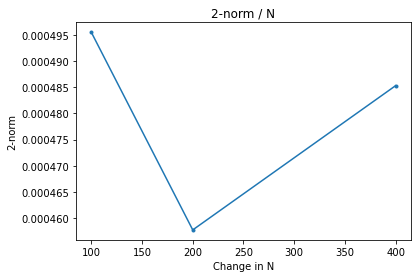

In [86]:
#plot for 2-norm
N = np.array([100,200,400])
#change N will give different plots

norm2 = []
for n in N:
    norm2.append(find_norm2(linear_system, n))
    
#i2 = np.argmin(norm2)

plt.plot(N, norm2, marker='.')
#plt.plot(N[i2], norm2[i2], marker='o', label='minimum')
#plt.legend()
plt.xlabel("Change in N")
plt.ylabel("2-norm")
plt.title("2-norm / N")
print(norm2)


Text(0.5, 1.0, 'infinite norm / N')

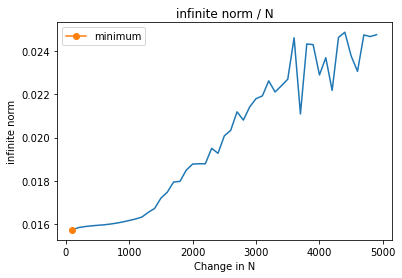

In [8]:
#plot for inf norm
N = np.arange(100, 5000, 100)
dt = t1 / N
norminf = []
for n in N:
    norminf.append(find_norminf(linear_system, n))

i3 = np.argmin(norminf)

plt.plot(N, norminf)
plt.plot(N[i3], norminf[i3], marker='o', label='minimum')
plt.legend()
plt.xlabel("Change in N")
plt.ylabel("infinite norm")
plt.title("infinite norm / N")

Text(0.5, 1.0, '2-norm / N with 10 random W&B')

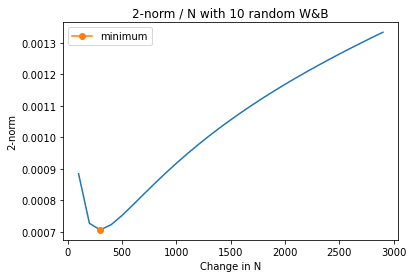

In [9]:
#plot for 2-norm for 10 different W/B realisations
N = np.arange(100, 3000, 100)
dt = t1 / N
it = 10
mean2 = np.zeros(len(N))
for w in range(it):
    norm2 = []
    W_i = pickw(w=0.005)
    B_i = pickb(b=4)
    for n in N:
        norm2.append(find_norm2(linear_system, n, w_0 = W_i, b_0 = B_i))
    mean2 = mean2 + np.array(norm2)
mean2 = mean2/it

i4 = np.argmin(mean2)

plt.plot(N, mean2)
plt.plot(N[i4], mean2[i4], marker='o', label='minimum')
plt.legend()
plt.xlabel("Change in N")
plt.ylabel("2-norm")
plt.title("2-norm / N with 10 random W&B")

Text(0.5, 1.0, 'max(ϵ) / N with 10 random W&B')

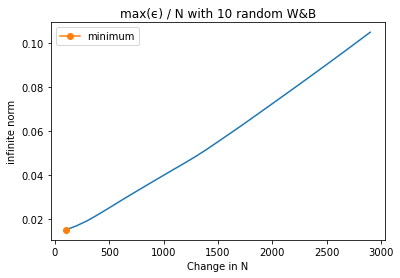

In [10]:
#plot for infinite norm for 10 different W/B realisations
N = np.arange(100, 3000, 100)
dt = t1 / N
it = 10
meaninf = np.zeros(len(N))
for w in range(it):
    norminf = []
    W_i = pickw(w=0.005)
    B_i = pickb(b=4)
    for n in N:
        norminf.append(find_norminf(linear_system, n, w_0 = W_i, b_0 = B_i))
    meaninf = meaninf + np.array(norminf)
meaninf = meaninf/it

i5 = np.argmin(meaninf)

plt.plot(N, meaninf)
plt.plot(N[i5], meaninf[i5], marker='o', label='minimum')
plt.legend()
plt.xlabel("Change in N")
plt.ylabel("infinite norm")
plt.title("max(ϵ) / N with 10 random W&B")

In [52]:
def find_approximation(system: callable, t0: float, t1: float,
                       N=100, D_r=100, w=0.005, b=4, beta=100):
    U: np.ndarray = system(np.linspace(t0, t1, N+1))
    D = U.shape[0]
    U_o = U[:, 1:]
    U_i = U[:, :-1]
    W_in = np.random.uniform(-w, w, (D_r, D))
    b_in = np.random.uniform(-b, b, (D_r,1))
    Phi = np.tanh(W_in @ U_i + b_in)
    W_LR = (U_o @ Phi.T @ inv(Phi @ Phi.T + beta * np.identity(D_r)))

    U_hat = np.atleast_2d(U[:, 0]).T
    for _ in range(N):
        u_n = U_hat[:, -1]
        phi = np.tanh(np.atleast_2d(W_in @ u_n).T + b_in)
        u_np1 = W_LR @ phi
        U_hat = np.concatenate((U_hat, u_np1), axis=1)
        
    U_pred = np.atleast_2d(U_hat[:, -1]).T
    for _ in range(N):
        u_n = U_pred[:, -1]
        phi = np.tanh(np.atleast_2d(W_in @ u_n).T + b_in)
        u_np1 = W_LR @ phi
        U_pred = np.concatenate((U_pred, u_np1), axis=1)
    #return U, U_hat
    return U, U_hat, U_pred

def find_norm2(system:callable, N_0, D_r0):
    U, U_hat, U_pred = find_approximation(system, t0, t1, N=N_0, D_r=D_r0)
    norm2 = 0
    for n in range(N_0):
        norm2 += (np.linalg.norm(U[:,n]-U_hat[:,n]) / np.linalg.norm(U[:,n]))**2
    return np.sqrt(norm2) / N_0

In [53]:
#Lorenz system
def get_lorenz_vals(dt):
    def lorenz1(xyz, t, s=10, r=28, b=8/3):
        x,y,z = xyz
        dx = s*(y - x)
        dy = r*x - y - x*z
        dz = x*y - b*z
        return np.array([dx,dy,dz])
    
    from scipy.integrate import odeint
    sol = odeint(lorenz1, [0,2,0], dt)
    xs,ys,zs = sol.T

    return sol.T

No handles with labels found to put in legend.


-0.6550929451766354


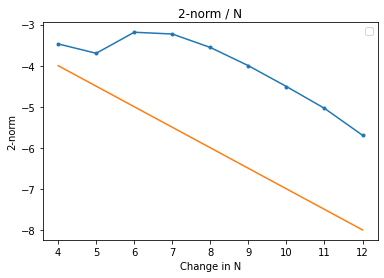

In [54]:
#plot for 2-norm
N = np.arange(4,13,1)

norm2 = []
for n in N:
    norm2.append(np.log2(find_norm2(get_lorenz_vals, 2**n, 2**n)))


#i2 = np.argmin(norm2)

plt.plot(N, norm2, marker=".")
plt.plot(N, -N/2-2)
#plt.plot(N[i2], norm2[i2], marker='o', label='minimum')
plt.legend()
plt.xlabel("Change in N")
plt.ylabel("2-norm")
plt.title("2-norm / N")
print((norm2[-1]-norm2[-2])/(N[-1]-N[-2]))

In [70]:
np.log(norm2[1]/norm2[0])/np.log(2)

0.06753448538365969

In [71]:
np.log(norm2[2]/norm2[1])/np.log(2)

0.21420237006445872

In [88]:
N = np.arange(4,10,1)
N

array([4, 5, 6, 7, 8, 9])